# The noisy student setup for HLA-A*02:01 RNN

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import seaborn as sns
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from sklearn.metrics import mean_squared_error

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


## The Network

In [12]:
def initialize_weights(m):
    """ Initializes weights for network

    Args:
        m (pytorch object): A layer in the network
    """
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.LSTM):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


Here, we load the RNN network structure and test that it works on random data

In [13]:
from model_structures import *
net = best_RNN()
print("Number of parameters in model:", get_n_params(net))
print(net)
peptide_random = np.random.normal(0,1, (10, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))
output = net(peptide_random,HLA_random)
print(output)


Number of parameters in model: 392801
best_RNN(
  (peptide_encoding): LSTM(12, 10, batch_first=True, bidirectional=True)
  (hla_encoding): LSTM(12, 10, batch_first=True, bidirectional=True)
  (drop_out): Dropout(p=0.4, inplace=False)
  (L_in): Linear(in_features=880, out_features=440, bias=True)
  (batchnorm1): BatchNorm1d(440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L_2): Linear(in_features=440, out_features=1, bias=True)
)
tensor([[0.5096],
        [0.3726],
        [0.5181],
        [0.3676],
        [0.4467],
        [0.5800],
        [0.3737],
        [0.6598],
        [0.3949],
        [0.5577]], grad_fn=<SigmoidBackward0>)


## Functions for loading and encoding data

In [14]:
def encode_peptide_onehot(aa_seq):
    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F','P', 'S', 'T', 'W', 'Y', 'V']
    one_hot_matrix = pd.DataFrame(np.identity(len(amino_acids)).astype("float32"))
    one_hot_matrix.index = amino_acids
    encoded_aa_seq = []

    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for _ in range(amino_acids)]))
        try:    
            encoded_aa_seq.append(one_hot_matrix.loc[aa].to_numpy())
        except KeyError:
            print("Encoding error")
            sys.exit(1)
    

    encoded_aa_seq = np.array(encoded_aa_seq)
    return encoded_aa_seq


def load_blossum62_matrix():
    from Bio.Align import substitution_matrices
    blosum62 = substitution_matrices.load("BLOSUM62")
    blossum_aas = list("ARNDCQEGHILKMFPSTWYVBZX*")
    blosum62 = pd.DataFrame(blosum62,columns=blossum_aas,index=blossum_aas)
    return blosum62


def encode_peptide_blossum65(aa_seq,blussom_matrix):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    AAs = blussom_matrix.shape[1]
    for aa in aa_seq:
        if aa == "-":
            encoded_aa_seq.append(np.array([0 for _ in range(AAs)]))
        else:
            try:
                encoded_aa_seq.append(blussom_matrix.loc[aa].to_numpy())
            except KeyError:
                print("Encoding error")
                sys.exit(1)
    

    encoded_aa_seq = np.array(encoded_aa_seq)
    # print(encoded_aa_seq.shape)

    return encoded_aa_seq


def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_multiple(aa_seq,aaindex_PCA,blussom_matrix):
    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F','P', 'S', 'T', 'W', 'Y', 'V']
    one_hot_matrix = pd.DataFrame(np.identity(len(amino_acids)).astype("float32"))
    one_hot_matrix.index = amino_acids
    encoded_aa_seq = []


    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(56)]))
        else:
            try:
                aa_index_encoding = aaindex_PCA.loc[aa].to_numpy()
                blossum_encoding = blussom_matrix.loc[aa].to_numpy()
                
                onehot_encoding = one_hot_matrix.loc[aa].to_numpy()
                encoding = np.concatenate((aa_index_encoding,blossum_encoding,onehot_encoding))
                encoded_aa_seq.append(encoding)

            except KeyError:
                print("Encoding error")
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aa_index_matrix,blosum62_matrix,HLA_dict,peptide_len,padding="right",semi_sup = False):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aa_index_matrix,row)
        # encoded_peptide = encode_peptide_onehot(peptide)
        # encoded_peptide = encode_peptide_blossum65(peptide,blosum62_matrix)
        # encoded_peptide = encode_multiple(peptide,aaindex_PCA,blosum62_matrix)

        binding_score = row['binding_score']

        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aa_index_matrix,row)
        # encoded_HLA = encode_peptide_onehot(HLA)
        # encoded_HLA = encode_peptide_blossum65(HLA,blosum62_matrix)
        # encoded_HLA = encode_multiple(HLA,aaindex_PCA,blosum62_matrix)


        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_binding_scores.append(binding_score)
        if not semi_sup:
            encoded_label = min(1,row["positive_subjects"])
            encoded_labels.append(encoded_label)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32').reshape(-1,1)
    
    
    if not semi_sup:
        encoded_labels = np.array(encoded_labels).astype('float32').reshape(-1,1)
        return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels
    
    else:
        return encoded_peptides, encoded_hlas, encoded_binding_scores


## Functions for plotting model statistics

In [15]:
def plot_epochs(K, lst_train_acc, lst_val_acc): 
    """For each fold, plot the accuracy on
    train and validation data for each epoch

    Args:
        K (int): Number of CV folds
        lst_train_acc (list of lists): list of lists containing training accuracy for each fold pr epoch
        lst_val_acc (list of lists): list of lists containing validation accuracy for each fold pr epoch
    """
    plt.figure()
    for i in range(K):
        epoch = np.arange(len(lst_train_acc[i]))
        plt.plot(epoch, lst_train_acc[i], 'r', epoch, lst_val_acc[i], 'b')
    # plt.title("Performance of {} fold CV".format(K))
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')
    plt.savefig("../plots/noisy_student.png",dpi=300)
    plt.show()


def calculate_avg_val_performance(K, N, lst_val_acc, lst_val_lab, lst_val_pred):
    """Calculate the generalization error

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        N (int): Total number of observations in data set
    """
    avg_recall = 0
    avg_accuracy = 0 
    avg_f1 = 0

    res = np.zeros((K,5))
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        n = len(lst_val_lab[i][best_epoch_model])
        accuracy = accuracy_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        recall = recall_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        f1 = f1_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])

        res[i][0] = best_epoch_model
        res[i][1] = n
        res[i][2] = accuracy
        res[i][3] = recall
        res[i][4] = f1

        avg_recall += (n/N) * recall
        avg_accuracy += (n/N) * accuracy
        avg_f1 += (n/N) * f1

    print(f"Best average results - Recall: {avg_recall} accuracy: {avg_accuracy} f1-score: {avg_f1}")
    return res

def plot_roc_curve_best_epoch(valid_losses, predictions, targets):
    """Plots the ROC curve for the best epoch

    Args:
        valid_losses (list): list of validation loss
        predictions (list of lists): model predictions for all epochs per CV fold
        targets (list of lists): target values for all epochs per CV fold
    """
    best_epoch_model = np.argmin(valid_losses)
    print("Best Epoch",best_epoch_model)
    fpr, tpr, threshold = metrics.roc_curve(targets[best_epoch_model],predictions[best_epoch_model])
    roc_auc = metrics.auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_PR_curve_best_epoch(valid_losses, predictions, targets):
    """Plots the PR curve for the best epoch

    Args:
        valid_losses (list): list of validation loss
        predictions (list of lists): model predictions for all epochs per CV fold
        targets (list of lists): target values for all epochs per CV fold
    """
    from sklearn import metrics
    best_epoch_model = np.argmin(valid_losses)
    precision, recall, thresholds = metrics.precision_recall_curve(targets[best_epoch_model], predictions[best_epoch_model])
    roc_auc = metrics.auc(recall, precision)
    plt.title('Precission-Recall curve')
    plt.plot(recall, precision, 'b', label = 'AUCpr = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Recall')
    plt.xlabel('Precession')
    plt.show()

def pick_optimal_threshold_auc(fpr, tpr, threshold):
    """Picks the optimal threshold for determining 
    immunogenic/non-immunogenic targets on unlabelled data

    Args:
        fpr (float): false positive rate  
        tpr (float): true positive rate
        threshold (float): The current threshold to update

    Returns:
        int: position of highest geometric mean
    """
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    return ix

def plot_all_roc_curves(K,valid_losses, predictions, targets):
    """Plot of ROC curve for all K CV folds

    Args:
        K (int): number of CV folds
        valid_losses (list): list of validation loss
        predictions (list of lists): model predictions for all epochs per CV fold
        targets (list of lists): target values for all epochs per CV fold
    """
    fig = plt.figure()
    plt.title('Receiver Operating Characteristic')
    for k in range(K):
        best_epoch_model = np.argmin(valid_losses[k])
    

        fpr, tpr, threshold = metrics.roc_curve(targets[k][best_epoch_model],predictions[k][best_epoch_model])
        roc_auc = round(metrics.auc(fpr,tpr),3)
        best_threshold = pick_optimal_threshold_auc(fpr, tpr, threshold)
        print(f"Best Epoch in K {k}",best_epoch_model,"best threshold:",threshold[best_threshold])
        plt.plot(fpr, tpr,label = f'CV {k+1} AUC {roc_auc}')
        plt.plot(fpr[best_threshold], tpr[best_threshold],color="black",marker="d")
        plt.plot()

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    
def plot_all_PR_curves(K,valid_losses, predictions, targets):
    """Plot of PR curve for all K CV folds

    Args:
        K (int): number of CV folds
        valid_losses (list): list of validation loss
        predictions (list of lists): model predictions for all epochs per CV fold
        targets (list of lists): target values for all epochs per CV fold
    """
    fig = plt.figure()
    plt.title('Receiver Operating Characteristic')
    for k in range(K):
        best_epoch_model = np.argmin(valid_losses[k])
        precision, recall, thresholds = metrics.precision_recall_curve(targets[k][best_epoch_model], predictions[k][best_epoch_model])
        roc_auc = round(metrics.auc(recall, precision),3)
        plt.plot(recall, precision,label = f'CV {k+1} AUC {roc_auc}')
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.show()


def plot_learning_curve(train_accuracies,val_accuracies):
    """Plot accuracy during training

    Args:
        train_accuracies (list): list of training accuracies on target values in current CV fold
        val_accuracies (list): list of validation accuracies on target values in current CV fold
    """
    epoch = np.arange(len(train_accuracies))
    plt.figure()
    plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')



def retrieve_best_clasification_threshold_semisup(predictions, targets):
    """Picks the optimal threshold for determining 
    immunogenic/non-immunogenic targets on unlabelled data

    Args:
        predictions (list): list of model predictions for current fold
        targets (list): list of target values for current fold

    Returns:
        float: the threshold that yields the best results with regards to TPR and FPR
    """
    fpr, tpr, threshold = metrics.roc_curve(targets,predictions)
    optimal_threshold_index = pick_optimal_threshold_auc(fpr, tpr, threshold)
    return threshold[optimal_threshold_index]

## Functions for training the models

In [23]:
def append_artificial_data_to_train(dataloader,add_0,add_1):
    """Appends artifical, labelled by model, data 
    to the training data before continuing to train

    Args:
        dataloader (pytorch dataloader): The training data loader to append to
        add_0 (list): List of non-immunogenic peptides
        add_1 (list): List of immunogenic peptides

    Returns:
        numpy array: training data with artificial data added
    """
    train_data = []
    for batch in dataloader:
        train_data += batch.numpy().tolist()
    train_data = np.array(train_data)
    return np.concatenate((train_data,add_0.numpy(),add_1.numpy()),axis=0)


def validation(model,device,valid_loaders,train_loaders):
    """Generates model predictions on train and validation data

    Args:
        model (pytorch model): trained neural network 
        device (state): either cuda enabled or not
        valid_loaders (Data loader): Data loader for validation data
        train_loaders (Data loader): Data loader for training data

    Returns:
        lists: lists of predictions, targets and validation loss
    """
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    with torch.no_grad():
        all_train_predictions = []
        all_train_targets = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i].to(device)
            train_HLA = HLA_train_loader[i].to(device)
            train_labels = label_train_loader[i].to(device)
            train_binding_scores = binding_score_train_loader[i].to(device)
            outputs = model(train_peptides,train_HLA)
            all_train_predictions += outputs.cpu().numpy().tolist()
            all_train_targets += train_labels.cpu().numpy().tolist()
        
        all_val_targets = []
        all_val_predictions = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j].to(device)
            val_HLA = HLA_val_loader[j].to(device)
            val_labels = label_val_loader[j].to(device)
            val_binding_scores = binding_score_val_loader[j].to(device)
            outputs = model(val_peptides,val_HLA)
            all_val_predictions += outputs.cpu().numpy().tolist()
            all_val_targets += val_labels.cpu().numpy().tolist()

        validation_loss = mean_squared_error(all_val_targets,all_val_predictions)

    return all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,validation_loss

def create_artifical_datasat(dataloader,add_non_immunogenic,add_immunogenic):
    """Creates artificla dataset

    Args:
        dataloader (Data loader): Data loader for training data
        add_non_immunogenic (list):non immunogenic peptides to add
        add_immunogenic (list): immunogenic peptides to add

    Returns:
        array: array of new training data 
    """
    train_data = []
    for batch in dataloader:
        train_data += batch.numpy().tolist()
    train_data = np.array(train_data)
    return np.concatenate((train_data,add_non_immunogenic.numpy(),add_immunogenic.numpy()),axis=0)


def expand_training_data(model,train_loaders,semisup_loaders,threshold,N_added,batch_size):
    """Expand training data with noisy student data 

    Args:
        model (pytorch model): trained neural network
        train_loaders (Data loader):data loader of training data 
        semisup_loaders (Data loader): data loader of training data 
        threshold (float): threshold for immunogenic/non-immunogenic label
        N_added (int): number of artificial data to add
        batch_size (int): batch size for new data loaders 

    Returns:
        data loaders: artifical data loaders
    """
    # Loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    peptide_semisup_loader,HLA_semisup_loader,binding_score_semisup_loader = semisup_loaders
    model.eval()
    with torch.no_grad():
        # Only one batch thus indexed using 0
        semisup_peptides = peptide_semisup_loader[0]
        semisup_HLA = HLA_semisup_loader[0]
        semisup_binding_scores = binding_score_semisup_loader[0]
        outputs = model(semisup_peptides,semisup_HLA).numpy()
    
    # Find predictions above and below threshold for immunogenecity
    indexes_immunogenic = np.where(outputs >= threshold)[0]
    indexes_non_immunogenic = np.where(outputs < threshold)[0]
    # Sample from the predictions
    indexes_immunogenic = np.random.choice(indexes_immunogenic,size=N_added,replace=False)
    indexes_non_immunogenic = np.random.choice(indexes_non_immunogenic,size=N_added,replace=False)
    # Create artifical dataset
    aritificial_peptides = create_artifical_datasat(peptide_train_loader,peptide_semisup_loader[0][indexes_non_immunogenic],peptide_semisup_loader[0][indexes_immunogenic])
    aritificial_HLA = create_artifical_datasat(HLA_train_loader,HLA_semisup_loader[0][indexes_non_immunogenic],HLA_semisup_loader[0][indexes_immunogenic])
    aritificial_binding_scores = create_artifical_datasat(binding_score_train_loader,binding_score_semisup_loader[0][indexes_non_immunogenic],binding_score_semisup_loader[0][indexes_immunogenic])
    
    artifical_immunogenic_labels = torch.tensor([0 for i in range(len(indexes_non_immunogenic))]).view(-1,1)
    artifical_nonimmunogenic_labels = torch.tensor([0 for i in range(len(indexes_non_immunogenic))]).view(-1,1)
    aritificial_labels = create_artifical_datasat(label_train_loader,artifical_immunogenic_labels,artifical_nonimmunogenic_labels)

    # Shuffling the data with the same indexes to retain the same Peptides to HLA's and binding scores
    shuffle_indexes = np.random.choice(len(aritificial_peptides),len(aritificial_peptides),replace=False)
    aritificial_peptides = aritificial_peptides[shuffle_indexes].astype("float32")
    aritificial_HLA = aritificial_HLA[shuffle_indexes].astype("float32")
    aritificial_binding_scores = aritificial_binding_scores[shuffle_indexes].astype("float32")
    aritificial_labels = aritificial_labels[shuffle_indexes].astype("float32")

    # Creating the dataloaders
    aritificial_peptides_loader = list(DataLoader(aritificial_peptides,batch_size=batch_size))
    aritificial_HLA_loader = list(DataLoader(aritificial_HLA,batch_size=batch_size))
    aritificial_binding_scores_loader = list(DataLoader(aritificial_binding_scores,batch_size=batch_size))
    aritificial_labels_loader = list(DataLoader(aritificial_labels,batch_size=batch_size))

    return aritificial_peptides_loader, aritificial_HLA_loader, aritificial_binding_scores_loader, aritificial_labels_loader





def train(model, device, epochs, train_loaders, valid_loaders, semisup_loaders):
    """train the model 

    Args:
        model (pytorch model): untrained neural network
        device (state): cuda enabled or not
        epochs (int): number of epoch to do
        train_loaders (Data loaders): Data loaders for training data
        valid_loaders (Data loaders): Data loaders for validation data
        semisup_loaders (Data loaders): Data loaders for noisy student data

    Returns:
        pytorch model: trained neural network
        lists: train and validation losses
    """
    
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders

    
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

    # Early stopping
    the_last_loss = 100
    patience = 100000
    trigger_times = 0
    
    all_val_targets_pr_epoch = []
    all_val_predictions_pr_epoch = []

    train_losses = []
    val_losses = []

    semisup_epoch = [20,40,60,80] # 20 
    addition = [100,100,100,100]
    
    for epoch in range(epochs):
        model.train()
        current_loss = 0
        
        for train_batch_index in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[train_batch_index].to(device)
            train_HLA = HLA_train_loader[train_batch_index].to(device)
            train_labels = label_train_loader[train_batch_index].to(device)
            train_binding_scores = binding_score_train_loader[train_batch_index].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(train_peptides,train_HLA)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
        train_losses.append(current_loss/len((peptide_train_loader)))

        all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,validation_loss = validation(model,device,valid_loaders,train_loaders)
        val_losses.append(validation_loss)
        all_val_targets_pr_epoch.append(all_val_targets)
        all_val_predictions_pr_epoch.append(all_val_predictions)

        if epoch % 1 == 0:
            print("Epoch %2i : Train Loss %f , Validation loss %f" % (epoch+1, train_losses[-1], val_losses[-1]))
        

        if epoch in semisup_epoch:
            addition_to_artificial = addition[semisup_epoch.index(epoch)]
            
            _,_,all_val_targets,all_val_predictions,_ = validation(model,device,valid_loaders,train_loaders)
            threshold_classifcation = retrieve_best_clasification_threshold_semisup(predictions=all_val_predictions,targets=all_val_targets)
            # aritificial_peptides_loader, aritificial_HLA_loader, aritificial_binding_scores_loader, aritificial_labels_loader = expand_training_data(model, train_loaders,semisup_loaders,threshold_classifcation, 100, batch_size)
            peptide_train_loader, HLA_train_loader, binding_score_train_loader, label_train_loader = expand_training_data(model, train_loaders,semisup_loaders,threshold_classifcation, addition_to_artificial, batch_size)
            
            
        # Early stopping
        the_current_val_loss = val_losses[-1]
        the_last_val_loss = 0 if len(val_losses) < 2 else val_losses[-2]

        # print('The current valdiation loss:', the_current_loss)
        # print(the_current_val_loss,the_last_val_loss)
        if the_current_val_loss > the_last_val_loss:
            trigger_times += 1
            # print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping at epoch',epoch," with patience",patience)
                return model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch

        else:
            # print('trigger times: 0')
            trigger_times = 0

    return model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)


Device state: cpu


## Encoding entire data set

In [17]:
# Loading the encoding schemes
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
# aaindex_PCA = pd.read_csv('../data/PCA_repr_aa_standardized.csv',index_col=0)
blosum62 = load_blossum62_matrix()
blosum62 = (blosum62 - np.mean(blosum62)) / np.std(blosum62)

# HLA
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
# hla_database = pd.read_csv('../data/MHC_full.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

# Reading the data 
all_data = pd.read_csv("../data/ifng_true_balanced_w_parts_w_binding_scores_w_iedb.csv")
all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)

# Filtering for 9-mers from HLA-A*02:01
# all_data["peptide_len"] = all_data["peptide"].apply(len)
# all_data = all_data[(all_data["HLA_allele"] == "HLA-A*02:01") & (all_data["peptide_len"] == 9)]

print("## Encoding dataset")
all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,aaindex_PCA,blosum62,hla_dic,peptide_len=10,padding="right")
print("Shape of peptides",all_peptides_encoded.shape)
print("Shape of hla",all_HLA_encoded.shape)
print("Shape of binding_scores",all_binding_scores_encoded.shape)


print("## Encoding semi-supervised")
semisup_data = pd.read_csv("../data/semi_supervised_data_w_binding_no_overlap_astrid.csv")
semisup_data = semisup_data.sample(frac=1, random_state=1).reset_index(drop=True)
semisup_data["peptide_len"] = semisup_data["peptide"].apply(len)
# semisup_data = semisup_data[(semisup_data["HLA_allele"] == "HLA-A*02:01") & (semisup_data["peptide_len"] == 9)]
semisup_peptides_encoded, semisup_HLA_encoded, semisup_binding_scores_encoded = encode_dataset(semisup_data,aaindex_PCA,blosum62,hla_dic,peptide_len=10,padding="right",semi_sup=True)

print("Shape of peptides",semisup_peptides_encoded.shape)
print("Shape of hla",semisup_HLA_encoded.shape)
print("Shape of binding_scores",semisup_binding_scores_encoded.shape)


## Encoding dataset


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Shape of peptides (3228, 10, 12)
Shape of hla (3228, 34, 12)
Shape of binding_scores (3228, 1)
## Encoding semi-supervised
Shape of peptides (18015, 10, 12)
Shape of hla (18015, 34, 12)
Shape of binding_scores (18015, 1)


In [18]:
def occlude_peptide_position(input_data,occlusion_positions):
    input_data = input_data.copy()
    input_data[:,occlusion_positions,:] = 0
    return input_data

def occlusion_sensitivity_analysis(model, valid_loaders):
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    model.eval()
    import itertools
    positions = range(10)
    occlussions = [list(itertools.combinations(positions,1)),list(itertools.combinations(positions,2)),list(itertools.combinations(positions,3))]
    base_line_auc = 0.778
    with torch.no_grad():
        for length, occlusion_combinations in enumerate(occlussions):
            aucs = []
            occluded_positions = []
            for occlusion in occlusion_combinations:
                all_val_targets = []
                all_val_predictions = []
                occluded_positions.append(",".join([str(x) for x in occlusion]))
                for j in range(len((peptide_val_loader))):
                    val_peptides = peptide_val_loader[j].to(device)
                    occluded_peptides = torch.clone(val_peptides)
                    occluded_peptides[:,occlusion,:] = 0
                    val_HLA = HLA_val_loader[j].to(device)
                    val_labels = label_val_loader[j].to(device)
                    val_binding_scores = binding_score_val_loader[j].to(device)
                    outputs = model(occluded_peptides,val_HLA)
                    all_val_predictions += outputs.cpu().numpy().tolist()
                    all_val_targets += val_labels.cpu().numpy().tolist()
                fpr, tpr, threshold = metrics.roc_curve(all_val_targets,all_val_predictions)
                roc_auc = metrics.auc(fpr,tpr)
                aucs.append(roc_auc)
            
            tracker_dict = {x:y for x,y in zip(occluded_positions,aucs)}

            sorted_occlusions = sorted(tracker_dict.keys(), key= lambda x: tracker_dict[x])
            sorted_aucs = [tracker_dict[occ] for occ in sorted_occlusions]

            fig = plt.figure(figsize=(20,10))
            plt.bar(np.arange(len(aucs)), sorted_aucs)
            plt.xticks(np.arange(len(aucs)),sorted_occlusions,rotation=90, size=8)
            plt.ylim(0.5,1)
            plt.axhline(base_line_auc,color="r",ls="--")
            plt.show()
    

## 5-fold cross-validation loop

In [19]:
N = len(all_data)
no_epoch = 100

testing = True

batch_size = 40 # 60 got high performance

lst_train_accuracies = []
lst_val_losses = []
lst_val_predictions = []
lst_val_labels = []

test_parts = [1]
validation_parts = [0]
training_parts = [j for j in range(2,10)]


## The partitions to use for training, validation ##
# indexes = [x for x in range(len(all_data))]
# train_indexes = random.sample(indexes,int(len(all_data)*0.9))
# valid_indexes = [x for x in indexes if x not in train_indexes]

# train_peptides_encoded = all_peptides_encoded[train_indexes]
# train_HLA_encoded = all_HLA_encoded[train_indexes]
# train_binding_scores_encoded = all_binding_scores_encoded[train_indexes]
# train_label_encoded = all_label_encoded[train_indexes]

# val_peptides_encoded = all_peptides_encoded[valid_indexes]
# val_HLA_encoded = all_HLA_encoded[valid_indexes]
# val_binding_scores_encoded = all_binding_scores_encoded[valid_indexes]
# val_label_encoded = all_label_encoded[valid_indexes]


train_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(training_parts)]
train_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(training_parts)]
train_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(training_parts)]
train_label_encoded = all_label_encoded[all_data["parts"].isin(training_parts)]

val_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(validation_parts)]
val_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(validation_parts)]
val_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(validation_parts)]
val_label_encoded = all_label_encoded[all_data["parts"].isin(validation_parts)]

test_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(test_parts)]
test_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(test_parts)]
test_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(test_parts)]
test_label_encoded = all_label_encoded[all_data["parts"].isin(test_parts)]


## Batches for training the model ##
peptide_train_loader = list(DataLoader(train_peptides_encoded,batch_size=batch_size))
HLA_train_loader = list(DataLoader(train_HLA_encoded,batch_size=batch_size))
binding_score_train_loader = list(DataLoader(train_binding_scores_encoded,batch_size=batch_size))
label_train_loader = list(DataLoader(train_label_encoded,batch_size=batch_size))

peptide_val_loader = list(DataLoader(val_peptides_encoded,batch_size=batch_size))
HLA_val_loader = list(DataLoader(val_HLA_encoded,batch_size=batch_size))
binding_score_val_loader = list(DataLoader(val_binding_scores_encoded,batch_size=batch_size))
label_val_loader = list(DataLoader(val_label_encoded,batch_size=batch_size))

peptide_semisup_loader = list(DataLoader(semisup_peptides_encoded,batch_size=len(semisup_peptides_encoded)))
HLA_semisup_loader = list(DataLoader(semisup_HLA_encoded,batch_size=len(semisup_peptides_encoded)))
binding_score_semisup_loader = list(DataLoader(semisup_binding_scores_encoded,batch_size=len(semisup_peptides_encoded)))


train_loaders = (peptide_train_loader, HLA_train_loader, label_train_loader, binding_score_train_loader)
val_loaders = (peptide_val_loader, HLA_val_loader, label_val_loader, binding_score_val_loader)
semi_loaders = (peptide_semisup_loader,HLA_semisup_loader,binding_score_semisup_loader)

torch.manual_seed(0)
net = best_RNN()
net.apply(initialize_weights)

trained_model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch = train(net,device,no_epoch,train_loaders,val_loaders,semi_loaders)

lst_train_accuracies.append(train_losses)
lst_val_losses.append(val_losses)
lst_val_labels.append(all_val_targets_pr_epoch)
lst_val_predictions.append(all_val_predictions_pr_epoch)

Epoch  1 : Train Loss 0.278900 , Validation loss 0.244860
Epoch  2 : Train Loss 0.247605 , Validation loss 0.239284
Epoch  3 : Train Loss 0.233102 , Validation loss 0.224350
Epoch  4 : Train Loss 0.219285 , Validation loss 0.225994
Epoch  5 : Train Loss 0.206973 , Validation loss 0.218557
Epoch  6 : Train Loss 0.203640 , Validation loss 0.214175
Epoch  7 : Train Loss 0.198917 , Validation loss 0.217008
Epoch  8 : Train Loss 0.189966 , Validation loss 0.209749
Epoch  9 : Train Loss 0.184486 , Validation loss 0.213306
Epoch 10 : Train Loss 0.181936 , Validation loss 0.211284
Epoch 11 : Train Loss 0.178590 , Validation loss 0.214632
Epoch 12 : Train Loss 0.173201 , Validation loss 0.209384
Epoch 13 : Train Loss 0.169830 , Validation loss 0.212450
Epoch 14 : Train Loss 0.165046 , Validation loss 0.210861
Epoch 15 : Train Loss 0.158717 , Validation loss 0.205308
Epoch 16 : Train Loss 0.156706 , Validation loss 0.208414
Epoch 17 : Train Loss 0.149145 , Validation loss 0.206103
Epoch 18 : Tra

## Statistics for network

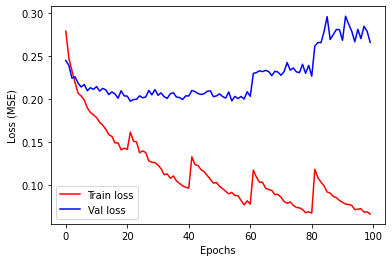

Best Epoch in K 0 21 best threshold: 0.4316152334213257


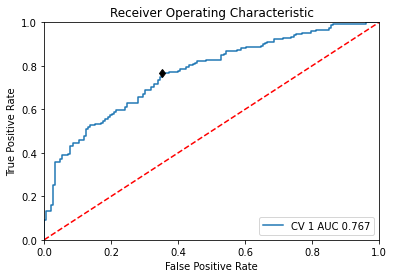

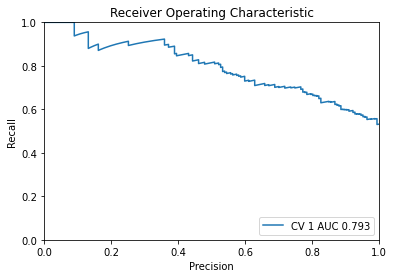

In [22]:
def plot_epochs(K, lst_train_acc, lst_val_acc): 
    plt.figure()
    for i in range(K):
        epoch = np.arange(len(lst_train_acc[i]))
        plt.plot(epoch, lst_train_acc[i], 'r', epoch, lst_val_acc[i], 'b')
    # plt.title("Performance of {} fold CV".format(K))
    plt.legend(['Train loss','Val loss'])
    plt.xlabel('Epochs'), plt.ylabel('Loss (MSE)')
    plt.savefig("../plots/noisy_student.png",dpi=300)
    plt.show()
# line plot
plot_epochs(1, lst_train_accuracies, lst_val_losses)
plot_all_roc_curves(1,lst_val_losses,lst_val_predictions,lst_val_labels)
plot_all_PR_curves(1,lst_val_losses,lst_val_predictions,lst_val_labels)

[5, 0, 4, 2, 1, 8, 6, 3, 7]
[0.12397181577491552, 0.11871576719375242, 0.11478615953043571, 0.10958617264675742, 0.10389220816448717, 0.10288203984188488, 0.09836325547103993, 0.09056221737764537, 0.08949916066118957]
[0.021308814036457225, 0.01821235125531222, 0.021473113456483305, 0.02218674867148758, 0.0201613637415207, 0.02326965413556999, 0.023006701639001613, 0.023932066126151456, 0.020161018998086953]


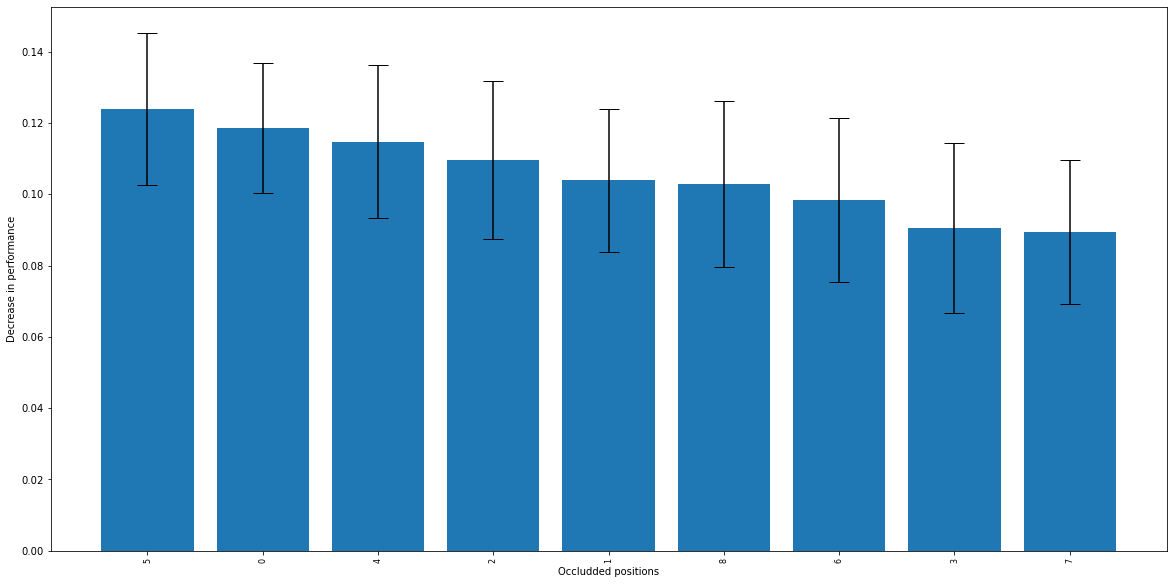

In [21]:
def occlusion_sensitivity_analysis(model, valid_loaders,N_positions,baseline_score):
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    model.eval()
    import itertools
    positions = range(N_positions)
    occlussions = [list(itertools.combinations(positions,1)),list(itertools.combinations(positions,2)),list(itertools.combinations(positions,3))] #
    base_line_auc = baseline_score
    position_occlusion_dict = {pos:[] for pos in range(N_positions)}

    with torch.no_grad():
        for length, occlusion_combinations in enumerate(occlussions):
            for occlusion in occlusion_combinations:
                all_val_targets = []
                all_val_predictions = []
                for j in range(len((peptide_val_loader))):
                    val_peptides = peptide_val_loader[j].to(device)
                    occluded_peptides = torch.clone(val_peptides)
                    occluded_peptides[:,occlusion,:] = 0
                    val_HLA = HLA_val_loader[j].to(device)
                    val_labels = label_val_loader[j].to(device)
                    val_binding_scores = binding_score_val_loader[j].to(device)
                    outputs = model(occluded_peptides,val_HLA)
                    all_val_predictions += outputs.cpu().numpy().tolist()
                    all_val_targets += val_labels.cpu().numpy().tolist()
                fpr, tpr, threshold = metrics.roc_curve(all_val_targets,all_val_predictions)
                roc_auc = metrics.auc(fpr,tpr)
                difference_from_baseline = base_line_auc-roc_auc
                for occluded_position in occlusion:
                    position_occlusion_dict[occluded_position].append(difference_from_baseline)
    

    
    average_decrease_in_performance = {pos:np.mean(position_occlusion_dict[pos]) for pos in position_occlusion_dict.keys()}
    std_decrease_in_performance = {pos:np.std(position_occlusion_dict[pos]) for pos in position_occlusion_dict.keys()}

    sorted_occlusions = sorted(average_decrease_in_performance.keys(), key= lambda x: average_decrease_in_performance[x],reverse=True)
    sorted_decreases = [average_decrease_in_performance[occ] for occ in sorted_occlusions]
    sorted_std =  [std_decrease_in_performance[occ] for occ in sorted_occlusions]

    print(sorted_occlusions)
    print(sorted_decreases)
    print(sorted_std)
    
    fig = plt.figure(figsize=(20,10))
    plt.bar(np.arange(len(sorted_decreases)), sorted_decreases)
    plt.errorbar(np.arange(len(sorted_decreases)), sorted_decreases,yerr=sorted_std, fmt="", color="k", ls="",capsize=10)
    plt.xticks(np.arange(len(sorted_decreases)),sorted_occlusions,rotation=90, size=8)
    plt.xlabel("Occludded positions")
    plt.ylabel("Decrease in performance")
    plt.show()

occlusion_sensitivity_analysis(trained_model, val_loaders, 9, 0.789)